In [1]:
# import necessary libraries for training xgboost model
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import time

In [2]:
# load the data
data_dir = '../mimic_data_after_preprocess/training_set_smote25.csv'
train = pd.read_csv(data_dir)
test = pd.read_csv('../mimic_data_after_preprocess/testing_set25.csv')

In [3]:
# since there is no instance in age group 1, remove this feature
train = train.drop(['age_1'], axis=1)
test = test.drop(['age_1'], axis=1)

In [4]:
# split the data into train and test
# train, test = train_test_split(debug_data, test_size=0.2)
# get features and labels
train_features = train.drop(['adverse_flag'], axis=1)
train_labels = train['adverse_flag']
test_features = test.drop(['adverse_flag'], axis=1)
test_labels = test['adverse_flag']

In [5]:
print('train features shape: ', train_features.shape)
print('train labels shape: ', train_labels.shape)
print('test features shape: ', test_features.shape)
print('test labels shape: ', test_labels.shape)
print('train features columns: ', train_features.columns)
print('test features columns: ', test_features.columns)

train features shape:  (90256, 25)
train labels shape:  (90256,)
test features shape:  (18478, 25)
test labels shape:  (18478,)
train features columns:  Index(['Unnamed: 0', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7',
       'age_8', 'gender', 'n_hosp', 'anti_narcotic', 'narcotic',
       'n_anti_narcotic', 'n_narcotic', 'oxymorphone', 'oxycodone', 'morphine',
       'meperidine', 'hydromorphone', 'hydrocodone', 'fentanyl', 'codeine',
       'buprenorphine', 'methadone', 'naloxone'],
      dtype='object')
test features columns:  Index(['subject_id', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7',
       'age_8', 'gender', 'n_hosp', 'anti_narcotic', 'narcotic',
       'n_anti_narcotic', 'n_narcotic', 'oxymorphone', 'oxycodone', 'morphine',
       'meperidine', 'hydromorphone', 'hydrocodone', 'fentanyl', 'codeine',
       'buprenorphine', 'methadone', 'naloxone'],
      dtype='object')


In [6]:
train_features = train_features.drop(['Unnamed: 0'], axis=1)
# train_features = train_features.drop(['subject_id'], axis=1)
test_features = test_features.drop(['subject_id'], axis=1)

In [7]:
print('train features shape: ', train_features.shape)
print('train labels shape: ', train_labels.shape)
print('test features shape: ', test_features.shape)
print('test labels shape: ', test_labels.shape)
print('train features columns: ', train_features.columns)
print('test features columns: ', test_features.columns)

train features shape:  (90256, 24)
train labels shape:  (90256,)
test features shape:  (18478, 24)
test labels shape:  (18478,)
train features columns:  Index(['age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'gender',
       'n_hosp', 'anti_narcotic', 'narcotic', 'n_anti_narcotic', 'n_narcotic',
       'oxymorphone', 'oxycodone', 'morphine', 'meperidine', 'hydromorphone',
       'hydrocodone', 'fentanyl', 'codeine', 'buprenorphine', 'methadone',
       'naloxone'],
      dtype='object')
test features columns:  Index(['age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'gender',
       'n_hosp', 'anti_narcotic', 'narcotic', 'n_anti_narcotic', 'n_narcotic',
       'oxymorphone', 'oxycodone', 'morphine', 'meperidine', 'hydromorphone',
       'hydrocodone', 'fentanyl', 'codeine', 'buprenorphine', 'methadone',
       'naloxone'],
      dtype='object')


In [8]:
test_features, vali_features, test_labels, vali_labels = train_test_split(test_features,
                                                                            test_labels,
                                                                            test_size=0.5)

In [9]:
print('train features shape: ', train_features.shape)
print('test features shape: ', test_features.shape)
print('vali features shape: ', vali_features.shape)

train features shape:  (90256, 24)
test features shape:  (9239, 24)
vali features shape:  (9239, 24)


In [10]:
# use grid search to find the best parameters
model = xgb.XGBClassifier()
param_grid = {'max_depth': [3, 5, 8, 10],
              'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
              'n_estimators': [50, 100, 150, 200, 300, 400],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2],
             "objective": ['binary:logistic'],
             "tree_method": ['hist']}
clf = GridSearchCV(model, param_grid, n_jobs=8, verbose=3, scoring='roc_auc')

In [11]:

model_cpu = xgb.XGBClassifier(max_depth=3,
                          learning_rate=0.1,
                          n_estimators=200,
                          min_child_weight = 1,
                          objective='binary:logistic',
                          tree_method='hist')
start_cpu = time.time()
model_cpu.fit(train_features, train_labels)
time_cost_cpu = time.time() - start_cpu
print('time cost of cpu: ', time_cost_cpu)

time cost of cpu:  1.779017686843872


In [12]:
# recall is true positive / (true positive + false negative)
# precision is true positive / (true positive + false positive)
# f1 is 2 * (precision * recall) / (precision + recall)
# auc is the area under the roc curve
# roc is the curve of true positive rate and false positive rate
preds = model_cpu.predict(test_features)
recall = recall_score(test_labels, preds)
precision = precision_score(test_labels, preds)
f1 = f1_score(test_labels, preds)
auc = roc_auc_score(test_labels, preds)
print('recall: ', recall)
print('precision: ', precision)
print('f1: ', f1)
print('auc: ', auc)
print()

# test model on training set
preds_train = model_cpu.predict(train_features)
recall_train = recall_score(train_labels, preds_train)
precision_train = precision_score(train_labels, preds_train)
f1_train = f1_score(train_labels, preds_train)
auc_train = roc_auc_score(train_labels, preds_train)
print('recall_train: ', recall_train)
print('precision_train: ', precision_train)
print('f1_train: ', f1_train)
print('auc_train: ', auc_train)


recall:  0.5021834061135371
precision:  0.29336734693877553
f1:  0.3703703703703704
auc:  0.7357198939557696

recall_train:  0.5746496039000609
precision_train:  0.8243662083763809
f1_train:  0.6772213880002611
auc_train:  0.7720211526182669


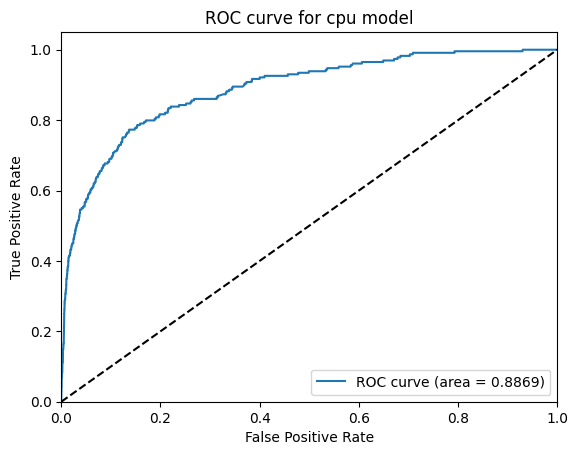

In [13]:
# plot the roc curve for cpu model

import matplotlib.pyplot as plt
probas_ = model_cpu.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probas_[:, 1])
auc = roc_auc_score(test_labels, probas_[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for cpu model')
plt.legend(loc="lower right")
plt.show()

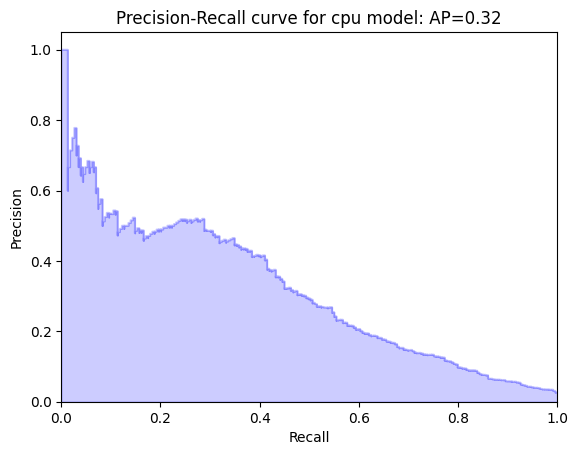

In [14]:
# plot the precision recall curve for cpu model

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, _ = precision_recall_curve(test_labels, probas_[:, 1])
average_precision = average_precision_score(test_labels, probas_[:, 1])
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for cpu model: AP={0:0.2f}'.format(
          average_precision))
plt.show()

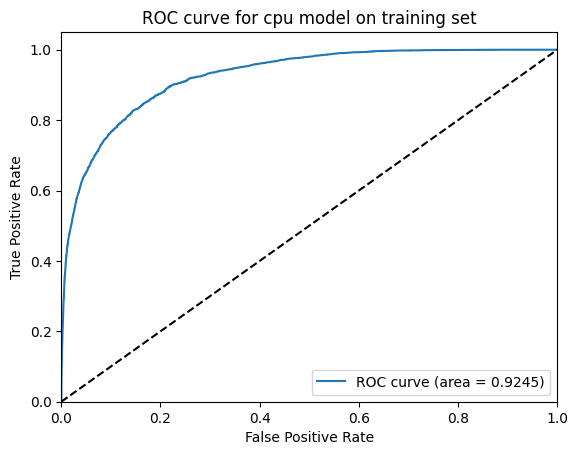

In [15]:
# plot the roc curve for cpu model on training set

import matplotlib.pyplot as plt
probas_ = model_cpu.predict_proba(train_features)
fpr, tpr, thresholds = roc_curve(train_labels, probas_[:, 1])
auc = roc_auc_score(train_labels, probas_[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for cpu model on training set')
plt.legend(loc="lower right")
plt.show()

In [39]:
# find the optimal threshold on roc curve
probas_ = model_cpu.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probas_[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
thresholdOpt = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdOpt, gmeans[ix]))
print('tpr: ', tpr[ix], 'fpr: ', fpr[ix])
print('precision: ', precision_score(test_labels, probas_[:,1] >= thresholdOpt))
print('recall: ', recall_score(test_labels, probas_[:,1] >= thresholdOpt))
print('f1_score: ', f1_score(test_labels, probas_[:,1] >= thresholdOpt))

# find the threshold that maximize the f1 score
thresholds_f1 = np.arange(0, 1, 0.01)
f1_scores = []
fpr_f1 = []
tpr_f1 = []
accuracy_f1 = []
precision_f1 = []
for threshold in thresholds_f1:
    preds_f1 = probas_[:,1] >= threshold
    f1_scores.append(f1_score(test_labels, preds_f1))
    tn, fp, fn, tp = confusion_matrix(test_labels, preds_f1).ravel()
    fpr_f1.append(fp / (fp + tn))
    tpr_f1.append(tp / (tp + fn))
    accuracy_f1.append((tp + tn) / (tp + tn + fp + fn))
    precision_f1.append(tp / (tp + fp))
thresholdOpt_f1 = thresholds_f1[np.argmax(f1_scores)]
print('thresholdOpt: ', thresholdOpt_f1)
print('tpr: ', tpr_f1[np.argmax(f1_scores)], 'fpr: ', fpr_f1[np.argmax(f1_scores)])
print('precision: ', precision_f1[np.argmax(f1_scores)])
print('recall: ', recall_score(test_labels, probas_[:,1] >= thresholdOpt_f1))
print('f1_score: ', np.max(f1_scores))
print('accuracy: ', accuracy_f1[np.argmax(f1_scores)])
# precision = tp / (tp + fp)

Best Threshold=0.200080, G-Mean=0.803
tpr:  0.7608695652173914 fpr:  0.15184815184815184
precision:  0.11341542449773169
recall:  0.7608695652173914
f1_score:  0.19740552735476596
thresholdOpt:  0.66
tpr:  0.41304347826086957 fpr:  0.015318015318015318
precision:  0.40772532188841204
recall:  0.41304347826086957
f1_score:  0.41036717062634986
accuracy:  0.970451347548436


In [47]:
print(precision_f1)

[0.024894469098387273, 0.03377473590239548, 0.03691386764216827, 0.03919134598333038, 0.04129904261310306, 0.04421699078812692, 0.046854377474703036, 0.050611657471815785, 0.05469366289771233, 0.056921801602652665, 0.06207744314689613, 0.06639004149377593, 0.07542675664946408, 0.08101157308186883, 0.08476881233000906, 0.0879695672848312, 0.09227683049147442, 0.09488666315234581, 0.09938922820655191, 0.1056422569027611, 0.11341542449773169, 0.11958041958041958, 0.12463343108504399, 0.1324345757335448, 0.134953897736798, 0.13922942206654992, 0.14102564102564102, 0.14381591562799617, 0.14741035856573706, 0.15400624349635797, 0.16100766703176342, 0.16627906976744186, 0.17401960784313725, 0.1828793774319066, 0.19099590723055934, 0.19746121297602257, 0.20501474926253688, 0.2073170731707317, 0.21669341894060995, 0.21710526315789475, 0.22487223168654175, 0.2328042328042328, 0.23626373626373626, 0.24423076923076922, 0.25301204819277107, 0.25661914460285135, 0.2616033755274262, 0.270089285714285

In [45]:
# store the model, and the tpr with regard to different thresholds
import pickle
with open('./models/model_xgboost.pkl', 'wb') as f:
    pickle.dump(model_cpu, f)
with open('./models/thresholds.pkl', 'wb') as f:
    pickle.dump(thresholds_f1, f)
with open('./models/tpr_xgboost.pkl', 'wb') as f:
    pickle.dump(tpr_f1, f)
with open('./models/precision_xgboost.pkl', 'wb') as f:
    pickle.dump(precision_f1, f)


In [34]:
pred_probas_default = probas_[:,1] >= 0.5
pred_probas_opt = probas_[:,1] >= thresholdOpt_f1

accuracy_default = accuracy_score(test_labels, pred_probas_default)
accuracy_opt = accuracy_score(test_labels, pred_probas_opt)

recall_default = recall_score(test_labels, pred_probas_default)
recall_opt = recall_score(test_labels, pred_probas_opt)

precision_default = precision_score(test_labels, pred_probas_default)
precision_opt = precision_score(test_labels, pred_probas_opt)

f1_default = f1_score(test_labels, pred_probas_default)
f1_opt = f1_score(test_labels, pred_probas_opt)

print('accuracy_default: ', accuracy_default)
print('accuracy_opt: ', accuracy_opt)
print('recall_default: ', recall_default)
print('recall_opt: ', recall_opt)
print('precision_default: ', precision_default)
print('precision_opt: ', precision_opt)
print('f1_default: ', f1_default)
print('f1_opt: ', f1_opt)

thresholdOpt = thresholdOpt_f1

accuracy_default:  0.957246455244074
accuracy_opt:  0.970451347548436
recall_default:  0.5130434782608696
recall_opt:  0.41304347826086957
precision_default:  0.2942643391521197
precision_opt:  0.40772532188841204
f1_default:  0.37400950871632327
f1_opt:  0.41036717062634986
